In [43]:
import pandas as pd
import numpy as np
import os
import random

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import TreebankWordTokenizer, sent_tokenize

import seaborn as sns
import matplotlib.pyplot as plt
from utils import print_score

from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import Ridge
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack

In [23]:
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

In [5]:
random.seed(42)
np.random.seed(42)
os.environ["PYTHONHASHSEED"] = str(42)

In [61]:
train = pd.read_csv('data/train.csv').drop('ID', axis=1)
test = pd.read_csv('data/test.csv').drop('ID', axis=1)
submission = pd.read_csv('data/sample_submission.csv')

In [62]:
train['new_facts'] = 'first_party: ' + train['first_party'] + ', second_party: ' + train['second_party'] + ', facts: ' + train['facts']
test['new_facts'] = 'first_party:' + test['first_party'] + ', second_party:' + test['second_party'] + ', facts:' + test['facts']
# train = train[['new_facts', 'first_party_winner']]
# test = test[['new_facts']]

# 전처리 (1)
- 문자열 좌우 공백 제거
- 두 칸 이상의 띄어쓰기 한 칸으로 변경
- 모든 단어 소문자화

In [63]:
cols = ['first_party', 'second_party', 'facts', 'new_facts']

# train, test 문자열 데이터의 좌우 공백 제거하기
for col in cols:
    train[col] = train[col].str.strip()
    test[col] = test[col].str.strip()

# 띄어쓰기가 두 칸 이상인 경우 한칸으로 변경
for col in cols:
    train[col] = train[col].str.replace('  ', ' ')
    test[col] = test[col].str.replace('  ', ' ')

for col in cols:
    train[col] = train[col].str.lower()
    test[col] = test[col].str.lower()

- 데이터 길이 EDA

train data의 최대 길이 :5862
train data의 평균 길이 :1191.313155770783


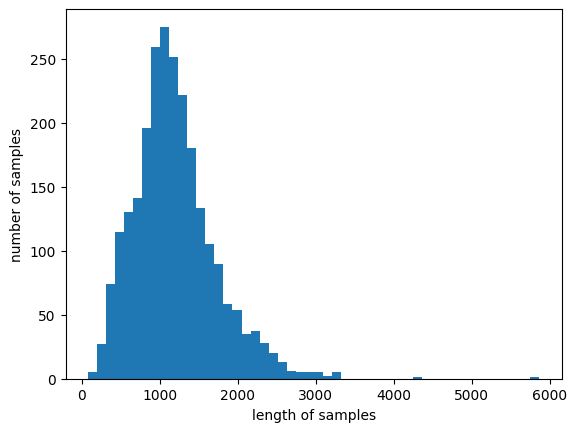

In [64]:
print('train data의 최대 길이 :{}'.format(max(len(sample) for sample in train['new_facts'])))
print('train data의 평균 길이 :{}'.format(sum(map(len, train['new_facts']))/len(train['new_facts'])))

plt.hist([len(sample) for sample in train['new_facts']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

test data의 최대 길이 :6173
test data의 평균 길이 :1189.925806451613


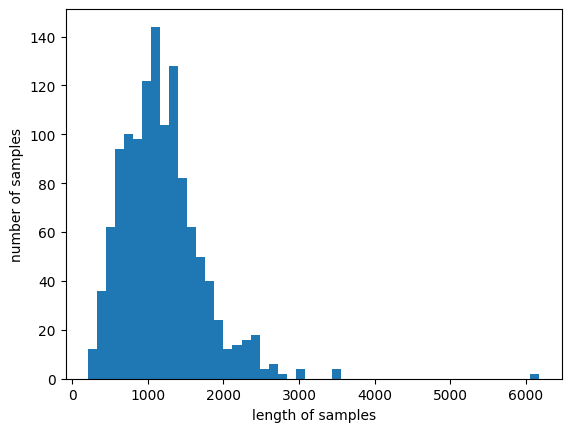

In [65]:
print('test data의 최대 길이 :{}'.format(max(len(sample) for sample in test['new_facts'])))
print('test data의 평균 길이 :{}'.format(sum(map(len, test['new_facts']))/len(test['new_facts'])))

plt.hist([len(sample) for sample in test['new_facts']], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

- 단어 길이 EDA

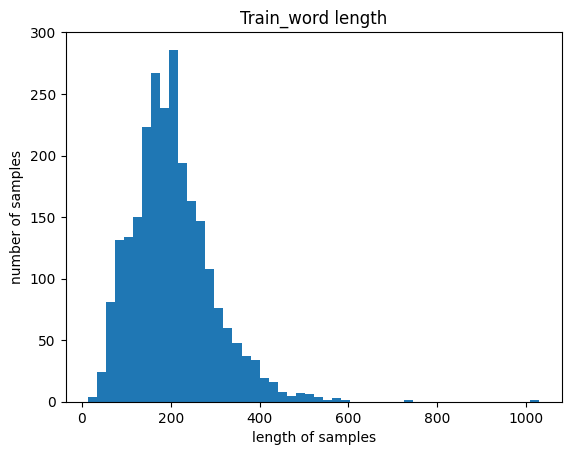

In [66]:
tokenizer = TreebankWordTokenizer()

len_word = []

for sample in train['new_facts']:
    len_word.append(len(tokenizer.tokenize(sample)))

plt.hist(len_word, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('Train_word length')
plt.show()

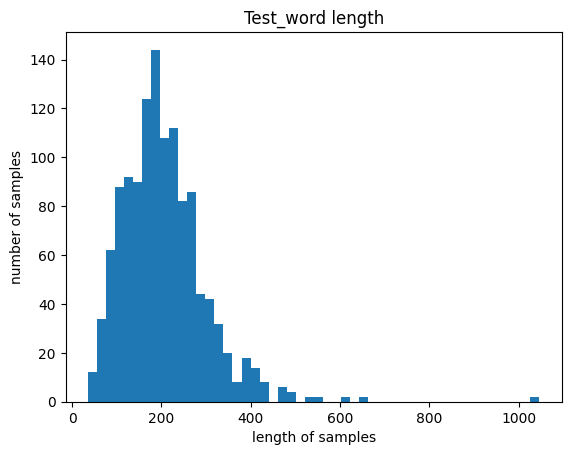

In [67]:
tokenizer = TreebankWordTokenizer()

len_word = []

for sample in test['new_facts']:
    len_word.append(len(tokenizer.tokenize(sample)))

plt.hist(len_word, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('Test_word length')
plt.show()

- 문장 길이 EDA

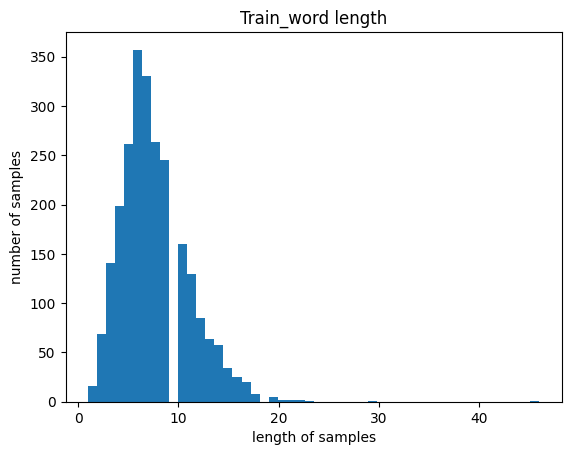

In [56]:
len_sentence = []

for sample in train['new_facts']:
    len_sentence.append(len(sent_tokenize(sample)))

plt.hist(len_sentence, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('Train_word length')
plt.show()

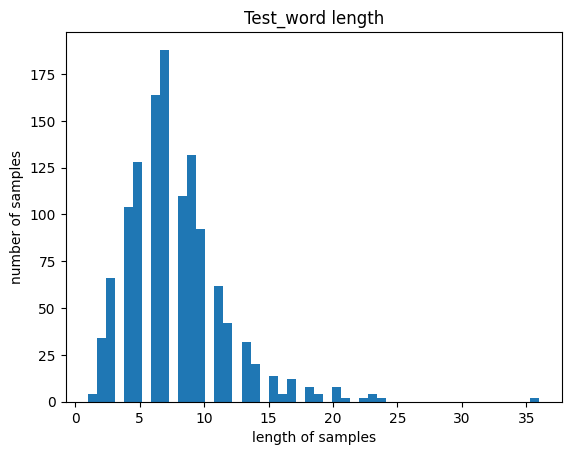

In [55]:
len_sentence = []

for sample in test['new_facts']:
    len_sentence.append(len(sent_tokenize(sample)))

plt.hist(len_sentence, bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.title('Test_word length')
plt.show()

# 전처리 (2)
- 토큰화
- 불용어 제거

In [89]:
train['first_party'][5]

'c & a carbone, inc., et al.'

In [94]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

TreebankWordTokenizer.tokenize(sent_tokenize(['first_party'][5]))

IndexError: list index out of range

In [68]:
stopwords = set(stopwords.words('english'))

['phil a. st. amant']

In [69]:
TreebankWordTokenizer().tokenize(train['first_party'][0])

['phil', 'a.', 'st.', 'amant']

In [58]:
sent_tokenize(train['facts'][0])

['On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.',
 'During this speech, St. Amant accused his political opponent of being a Communist and of being involved in criminal activities with the head of the local Teamsters Union.',
 'Finally, St. Amant implicated Herman Thompson, an East Baton Rouge deputy sheriff, in a scheme to move money between the Teamsters Union and St. Amant’s political opponent.',
 'Thompson successfully sued St. Amant for defamation.',
 'Louisiana’s First Circuit Court of Appeals reversed, holding that Thompson did not show St. Amant acted with “malice.” Thompson then appealed to the Supreme Court of Louisiana.',
 'That court held that, although public figures forfeit some of their First Amendment protection from defamation, St. Amant accused Thompson of a crime with utter disregard of whether the remarks were true.',
 'Finally, that court held that the First Amendment protects uninhibited, robust

In [82]:
import re
train['first_party'][5]
re.sub(' ', ' ', train['first_party'][5])

'c & a carbone, inc., et al.'

In [57]:
TreebankWordTokenizer().tokenize(train['facts'][0])

['On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St.',
 'Amant',
 ',',
 'a',
 'candidate',
 'for',
 'public',
 'office',
 ',',
 'made',
 'a',
 'television',
 'speech',
 'in',
 'Baton',
 'Rouge',
 ',',
 'Louisiana.',
 'During',
 'this',
 'speech',
 ',',
 'St.',
 'Amant',
 'accused',
 'his',
 'political',
 'opponent',
 'of',
 'being',
 'a',
 'Communist',
 'and',
 'of',
 'being',
 'involved',
 'in',
 'criminal',
 'activities',
 'with',
 'the',
 'head',
 'of',
 'the',
 'local',
 'Teamsters',
 'Union.',
 'Finally',
 ',',
 'St.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'an',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'in',
 'a',
 'scheme',
 'to',
 'move',
 'money',
 'between',
 'the',
 'Teamsters',
 'Union',
 'and',
 'St.',
 'Amant’s',
 'political',
 'opponent.',
 'Thompson',
 'successfully',
 'sued',
 'St.',
 'Amant',
 'for',
 'defamation.',
 'Louisiana’s',
 'First',
 'Circuit',
 'Court',
 'of',
 'Appeals',
 'reversed',
 ',',
 'holding',
 'that',
 'Thom

In [42]:
TreebankWordTokenizer().tokenize(train['new_facts'][0])

['first_party',
 ':',
 'Phil',
 'A.',
 'St.',
 'Amant',
 ',',
 'second_party',
 ':',
 'Herman',
 'A.',
 'Thompson',
 ',',
 'facts',
 ':',
 'On',
 'June',
 '27',
 ',',
 '1962',
 ',',
 'Phil',
 'St.',
 'Amant',
 ',',
 'a',
 'candidate',
 'for',
 'public',
 'office',
 ',',
 'made',
 'a',
 'television',
 'speech',
 'in',
 'Baton',
 'Rouge',
 ',',
 'Louisiana.',
 'During',
 'this',
 'speech',
 ',',
 'St.',
 'Amant',
 'accused',
 'his',
 'political',
 'opponent',
 'of',
 'being',
 'a',
 'Communist',
 'and',
 'of',
 'being',
 'involved',
 'in',
 'criminal',
 'activities',
 'with',
 'the',
 'head',
 'of',
 'the',
 'local',
 'Teamsters',
 'Union.',
 'Finally',
 ',',
 'St.',
 'Amant',
 'implicated',
 'Herman',
 'Thompson',
 ',',
 'an',
 'East',
 'Baton',
 'Rouge',
 'deputy',
 'sheriff',
 ',',
 'in',
 'a',
 'scheme',
 'to',
 'move',
 'money',
 'between',
 'the',
 'Teamsters',
 'Union',
 'and',
 'St.',
 'Amant’s',
 'political',
 'opponent.',
 'Thompson',
 'successfully',
 'sued',
 'St.',
 'Amant',

In [17]:
def get_vector(train_df, test_df):
    vect_first = TfidfVectorizer(analyzer='word', min_df=2)
    vect_second = TfidfVectorizer(analyzer='word', min_df=2)
    vect_facts = TfidfVectorizer(analyzer='word')
    
    X_party1 = vect_first.fit_transform(train_df['first_party'])
    X_party2 = vect_second.fit_transform(train_df['second_party'])
    X_facts = vect_facts.fit_transform(train_df['facts'])

    X_train = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)

    X_party1 = vect_first.transform(test_df['first_party'])
    X_party2 = vect_second.transform(test_df['second_party'])
    X_facts = vect_facts.transform(test_df['facts'])
    
    X_test = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X_train, X_test

TfidfVectorizer()

In [21]:
pd.DataFrame(vectorizer.transform(train['first_party']).toarray()).describe()

,0,1,2,3,4,5,6,7,8,9,...,2927,2928,2929,2930,2931,2932,2933,2934,2935,2936
count,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,...,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000,2478.000000
mean,0.000199,0.000212,0.000187,0.000191,0.000210,0.000188,0.000155,0.000156,0.000167,0.000207,...,0.000166,0.000293,0.000404,0.000269,0.000404,0.000336,0.000227,0.000316,0.000194,0.000404
std,0.009887,0.010577,0.009315,0.009524,0.010452,0.009380,0.007739,0.007787,0.008333,0.010323,...,0.008241,0.014564,0.020089,0.013391,0.020089,0.016715,0.011296,0.011106,0.009640,0.020089
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,0.492162,0.526500,0.463717,0.474104,0.520289,0.466941,0.385230,0.387651,0.414837,0.513862,...,0.410216,0.724970,1.000000,0.666598,1.000000,0.832077,0.562306,0.391016,0.479866,1.000000


In [ ]:
vectorizer = TfidfVectorizer()
def get_vector(vectorizer, df, train_mode):
    if train_mode:
        X_facts = vectorizer.fit_transform(df['facts'])
    else:
        X_facts = vectorizer.transform(df['facts'])
    X_party1 = vectorizer.transform(df['first_party'])
    X_party2 = vectorizer.transform(df['second_party'])
    
    X = np.concatenate([X_party1.todense(), X_party2.todense(), X_facts.todense()], axis=1)
    return X

In [9]:
print('first_party의 종류 개수 : ',train['first_party'].nunique())
print('first_party sample 7건 : \n', train['first_party'][:7])

first_party의 종류 개수 :  2110
first_party sample 7건 : 
 0              Phil A. St. Amant
1                 Stephen Duncan
2              Billy Joe Magwood
3                     Linkletter
4             William Earl Fikes
5    C & A Carbone, Inc., et al.
6         David Jennings, et al.
Name: first_party, dtype: object


In [10]:
print('second_party의 종류 개수 : ',train['second_party'].nunique())
print('second_party sample 7건 : \n', train['second_party'][:7])

second_party의 종류 개수 :  1974
second_party sample 7건 : 
 0                Herman A. Thompson
1                    Lawrence Owens
2    Tony Patterson, Warden, et al.
3                            Walker
4                           Alabama
5                Town of Clarkstown
6       Alejandro Rodriguez, et al.
Name: second_party, dtype: object


In [11]:
pd.set_option('max_colwidth',200)
print('facts 평균 문자열 크기 : ', train['facts'].str.len().mean())

train['facts'][:2]

facts 평균 문자열 크기 :  1109.0564971751412


0    On June 27, 1962, Phil St. Amant, a candidate for public office, made a television speech in Baton Rouge, Louisiana.  During this speech, St. Amant accused his political opponent of being a Commun...
1    Ramon Nelson was riding his bike when he suffered a lethal blow to the back of his head with a baseball bat. After two eyewitnesses identified Lawrence Owens from an array of photos and then a lin...
Name: facts, dtype: object

In [ ]:
# train, test 문자열 데이터의 좌우 공백 제거하기
for col in train.columns[:-1]:
    train[col] = train[col].str.strip()
for col in test.columns:
    test[col] = test[col].str.strip()